In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

import mlflow
import os

In [2]:
def read_dataframe(filename: str):
    df = pd.read_csv(filename)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(0, inplace=True)
    return df

def prepare_dataset(df: pd.DataFrame):
    df.drop('customerID', axis=1, inplace=True)
    return df

In [3]:
df_init = read_dataframe('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_base = prepare_dataset(df_init)
target = 'Churn'
X = df_base.drop(target, axis=1)
y = df_base[target]

# Split the data into training and test sets (75% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((5282, 19), (1761, 19))

In [4]:
os.environ["AWS_PROFILE"] = "jvaa-of" # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials

TRACKING_SERVER_HOST = "ec2-44-201-196-116.compute-1.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [5]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://ec2-44-201-196-116.compute-1.amazonaws.com:5000'


In [6]:
mlflow.set_experiment("Telco Churn Model Logistic Regression")

2023/08/22 00:41:38 INFO mlflow.tracking.fluent: Experiment with name 'Telco Churn Model Logistic Regression' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://vld-test-mlflow/4', creation_time=1692679299011, experiment_id='4', last_update_time=1692679299011, lifecycle_stage='active', name='Telco Churn Model Logistic Regression', tags={}>

In [11]:
with mlflow.start_run():
    params = dict(penalty='l2', solver='lbfgs', max_iter=500, random_state=42)
    
    mlflow.log_params(params)

    num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
    scaler = MinMaxScaler()

    categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

    encoder = OneHotEncoder(drop='first')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, num_features),
            ('cat', encoder, categorical_columns)
        ],
        remainder='passthrough'
    )

    pipeline = make_pipeline(preprocessor, LogisticRegression(**params))
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    mlflow.log_param("Model", "Logistic Regression")
    mlflow.log_metric("Accuracy", accuracy_score(y_test, predictions))
        
    mlflow.log_artifact("confusion-matrix.png")
    
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

mlflow.end_run()

c:\Anaconda3\envs\mlops-prj\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Anaconda3\envs\mlops-prj\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [10]:
print("accuracy_score:",accuracy_score(y_test, predictions))

accuracy_score: 0.8143100511073254


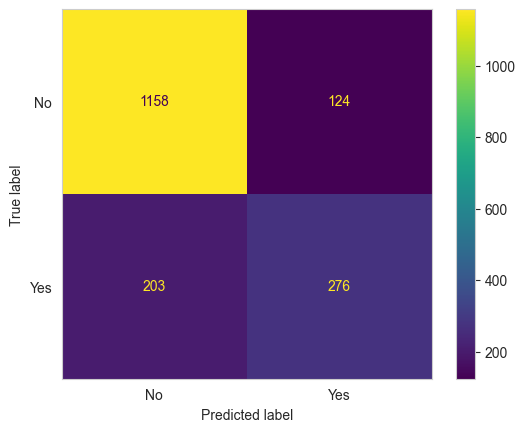

In [12]:
sns.set_style("whitegrid", {'axes.grid' : False})

ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.savefig("confusion-matrix.png")
plt.show()

### Using de model

In [13]:
customer = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 41,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'Yes',
    'OnlineBackup': 'No',
    'DeviceProtection': 'Yes',
    'TechSupport': 'Yes',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'One year',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Credit card (automatic)',
    'MonthlyCharges': 79.85,
    'TotalCharges': 3320.75,
}

In [14]:
df = pd.DataFrame([customer])

In [15]:
prediction = pipeline.predict(df)

In [16]:
prediction

array(['No'], dtype=object)

In [17]:
pipeline.predict_proba(df)[0,1]

0.06726537098332834